In [2]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [14]:
data = np.load('data/citeseer.npz')
print(data.files)
adj_indices = data['adj_indices']
adj_indptr = data['adj_indptr']
adj_data = data['adj_data']
adj_shape = data['adj_shape']

conset = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape)
#_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = conset + conset.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

['attr_indptr', 'attr_text', 'attr_data', 'idx_to_node', 'labels', 'idx_to_attr', 'adj_indptr', 'adj_indices', 'attr_indices', 'adj_shape', 'attr_shape', 'adj_data']
Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
rw_len = 16
batch_size = 64

In [7]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [8]:
walker.walk().__next__()

array([[1463, 1431, 1447, ..., 1493, 1618, 1450],
       [ 120,   31,   29, ...,  262,   66,   76],
       [ 818,  505, 1049, ..., 1487, 1539, 1487],
       ...,
       [ 372, 1045,  372, ...,  751, 1078,  714],
       [  35,  604,   35, ...,  297,  316,  253],
       [ 296,  297,  538, ...,    8,  148,   30]], dtype=int64)

#### Create our NetGAN model

In [9]:
tf.reset_default_graph()
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=64, W_down_generator_size=64,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

W0713 11:03:38.570117 10212 deprecation_wrapper.py:119] From C:\workspace\netgan-master\netgan\netgan.py:108: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0713 11:03:38.584086 10212 deprecation_wrapper.py:119] From C:\workspace\netgan-master\netgan\netgan.py:116: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 11:03:38.587046 10212 deprecation_wrapper.py:119] From C:\workspace\netgan-master\netgan\netgan.py:119: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0713 11:03:40.112797 10212 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an i

#### Define the stopping criterion

In [10]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."
if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [15]:
eval_every = 2000
plot_every = 2000

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_5.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****


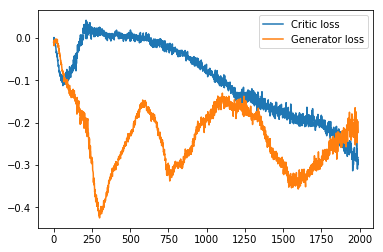

**** Iter 2000   Val ROC 0.806, AP: 0.831, EO 0.019 ****
2500   /200000   training iterations, took 373 seconds so far...


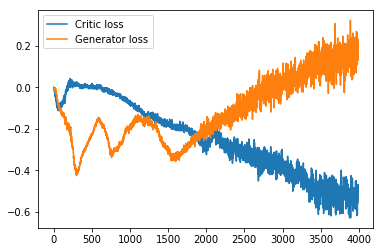

**** Iter 4000   Val ROC 0.878, AP: 0.883, EO 0.036 ****
5000   /200000   training iterations, took 747 seconds so far...


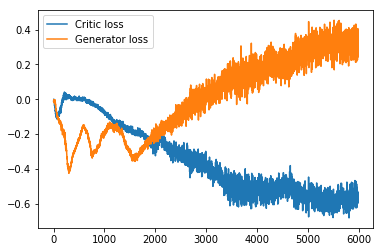

**** Iter 6000   Val ROC 0.915, AP: 0.919, EO 0.057 ****
7500   /200000   training iterations, took 1295 seconds so far...


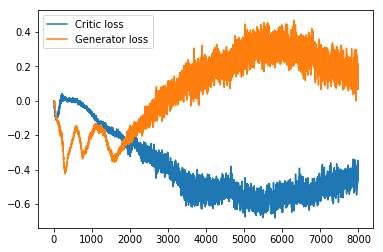

**** Iter 8000   Val ROC 0.937, AP: 0.942, EO 0.086 ****


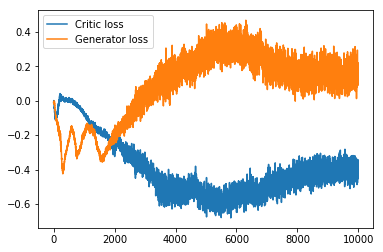

10000  /200000   training iterations, took 1766 seconds so far...
**** Iter 10000  Val ROC 0.951, AP: 0.955, EO 0.119 ****


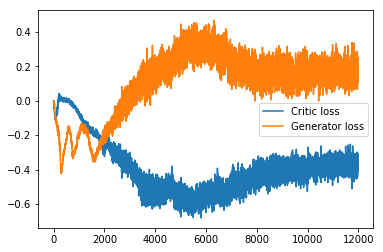

**** Iter 12000  Val ROC 0.952, AP: 0.955, EO 0.154 ****
12500  /200000   training iterations, took 2403 seconds so far...


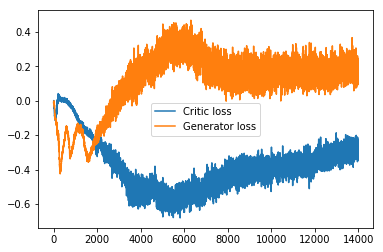

**** Iter 14000  Val ROC 0.954, AP: 0.961, EO 0.199 ****
15000  /200000   training iterations, took 2881 seconds so far...


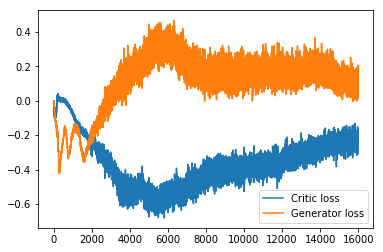

**** Iter 16000  Val ROC 0.948, AP: 0.954, EO 0.255 ****
17500  /200000   training iterations, took 3417 seconds so far...


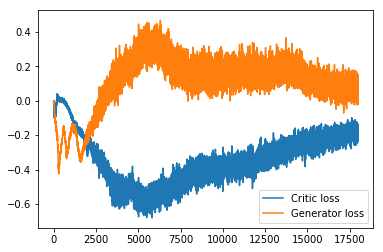

**** Iter 18000  Val ROC 0.942, AP: 0.951, EO 0.306 ****


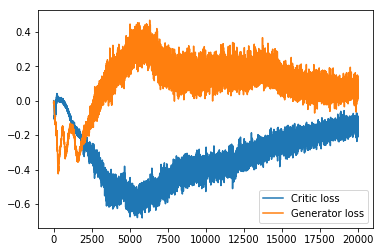

20000  /200000   training iterations, took 4364 seconds so far...
**** Iter 20000  Val ROC 0.941, AP: 0.949, EO 0.339 ****


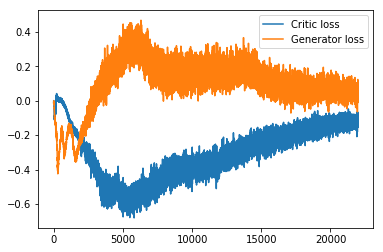

**** Iter 22000  Val ROC 0.948, AP: 0.952, EO 0.387 ****
22500  /200000   training iterations, took 5783 seconds so far...


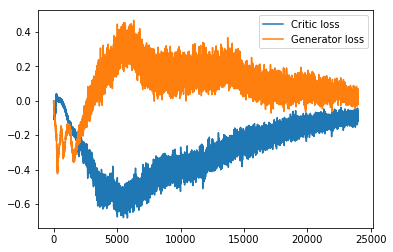

**** Iter 24000  Val ROC 0.938, AP: 0.946, EO 0.415 ****
25000  /200000   training iterations, took 6597 seconds so far...


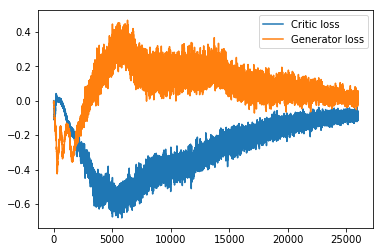

**** Iter 26000  Val ROC 0.937, AP: 0.944, EO 0.439 ****
27500  /200000   training iterations, took 7408 seconds so far...


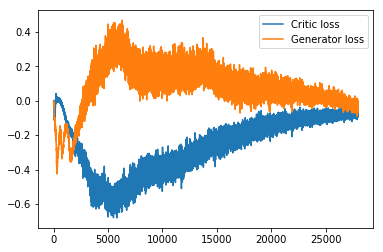

**** Iter 28000  Val ROC 0.937, AP: 0.946, EO 0.485 ****


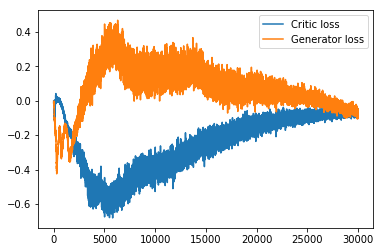

30000  /200000   training iterations, took 8215 seconds so far...
**** Iter 30000  Val ROC 0.930, AP: 0.940, EO 0.512 ****


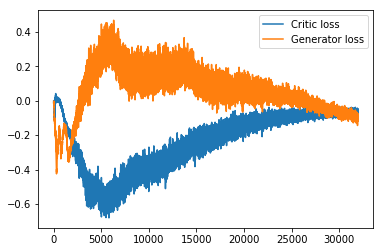

**** Iter 32000  Val ROC 0.933, AP: 0.940, EO 0.518 ****
32500  /200000   training iterations, took 9490 seconds so far...


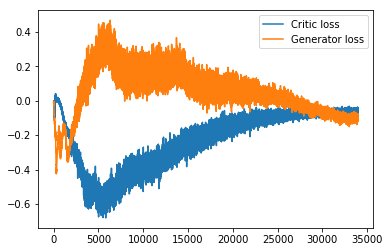

**** Iter 34000  Val ROC 0.932, AP: 0.940, EO 0.562 ****
35000  /200000   training iterations, took 10260 seconds so far...


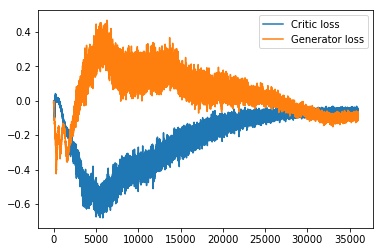

**** Iter 36000  Val ROC 0.929, AP: 0.936, EO 0.576 ****
37500  /200000   training iterations, took 11027 seconds so far...


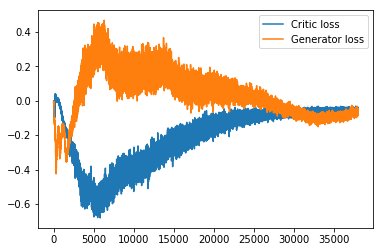

**** Iter 38000  Val ROC 0.928, AP: 0.934, EO 0.603 ****


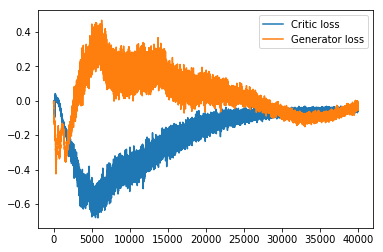

40000  /200000   training iterations, took 11796 seconds so far...
**** Iter 40000  Val ROC 0.918, AP: 0.926, EO 0.625 ****


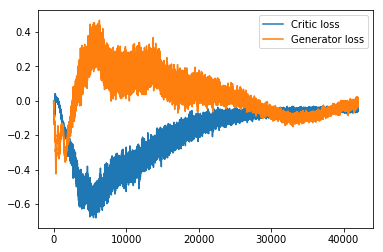

**** Iter 42000  Val ROC 0.928, AP: 0.933, EO 0.650 ****
42500  /200000   training iterations, took 13038 seconds so far...


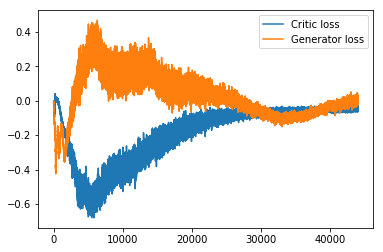

**** Iter 44000  Val ROC 0.923, AP: 0.929, EO 0.677 ****
45000  /200000   training iterations, took 13807 seconds so far...


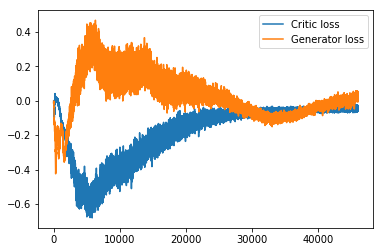

**** Iter 46000  Val ROC 0.914, AP: 0.921, EO 0.674 ****
47500  /200000   training iterations, took 14576 seconds so far...


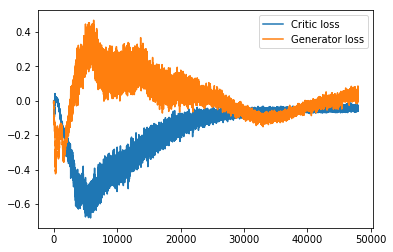

**** Iter 48000  Val ROC 0.915, AP: 0.924, EO 0.697 ****


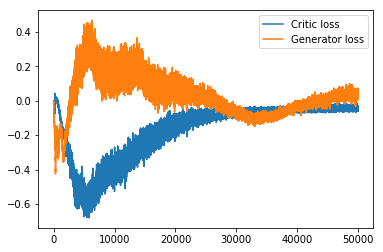

50000  /200000   training iterations, took 15344 seconds so far...
**** Iter 50000  Val ROC 0.924, AP: 0.929, EO 0.688 ****


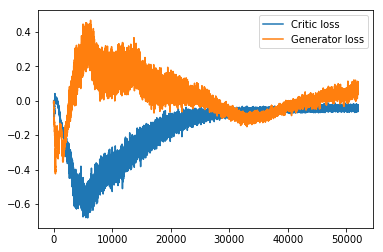

**** Iter 52000  Val ROC 0.917, AP: 0.923, EO 0.708 ****
52500  /200000   training iterations, took 16710 seconds so far...


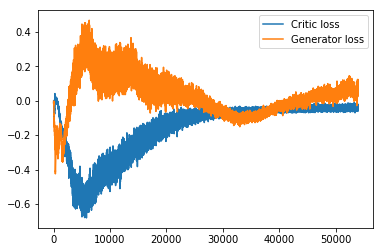

**** Iter 54000  Val ROC 0.919, AP: 0.924, EO 0.705 ****
**** EARLY STOPPING AFTER 54000 ITERATIONS ****
**** Training completed after 54000 iterations. ****


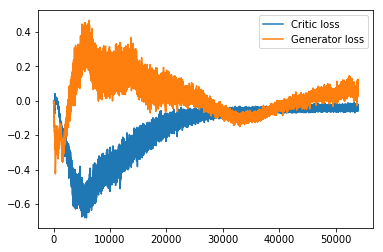

In [31]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, transitions_per_iter=50000,plot_every=plot_every, max_patience=20, max_iters=200000)

In [32]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

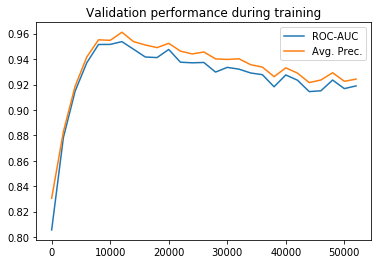

In [33]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

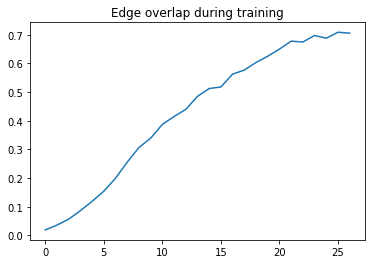

In [34]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [35]:
sample_many = netgan.generate_discrete(1000, reuse=True)

In [36]:
samples = []

In [37]:
for _ in range(600):
    if (_+1) % 50 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

49
99
149
199
249
299
349
399
449
499
549
599


#### Assemble score matrix from the random walks

In [38]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [39]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [40]:
roc_auc_score(test_labels, test_scores)

0.9408191030212048

In [41]:
average_precision_score(test_labels, test_scores)

0.9373945718008287